In [1]:
import numpy as np
import scipy as sp
import pylab as pl

import mxnet as mx
from mxnet import gluon

In [2]:
from gmm_base import *

In [3]:
ndims = 2
n_sample = int(1e4)
n_ranks = ndims
n_clusters = 7
epochs = 1000

In [4]:
gnd_mu_ = np.random.RandomState(0).rand(n_clusters, ndims)
gnd_cov_L_ = np.random.RandomState(1).randn(n_clusters, ndims, ndims) * 0.03

In [5]:
z = (np.random.RandomState(2).rand(n_sample) * n_clusters).astype(int)
x = gnd_mu_[z] + (gnd_cov_L_[z] @
                  np.random.RandomState(3).randn(n_sample, ndims)[:,:,None]
                 ).squeeze(axis=-1)

In [6]:
def plot_cov(mean, cov, **kw):
    vec, v2, _ = np.linalg.svd(cov)
    val = v2**0.5
    for r in range(len(val)):
        handle = pl.plot(*zip(
            mean - vec[:,r]*val[r],
            mean + vec[:,r]*val[r]), **kw)
    return handle

In [7]:
def Gaussian_log_pdf(ex, g_mean, g_cov):
    model = GMMModel(1, g_mean.size, g_mean[None,:], g_cov[None,:,:])
    model.initialize()
    return model(mx.nd.array(ex))[0].asnumpy()

In [8]:
def mixture_full_log_pdf(x, mu_, kR_):
    model = GMMModel(*mu_.shape, mu_, kR_)
    model.initialize()
    return model(mx.nd.array(x))[0].asnumpy()

In [9]:
g_mean = x.mean(axis=0)
g_cov = ((x-g_mean[None,:])[:,:,None] @ (x-g_mean[None,:])[:,None,:]).mean(axis=0)

(0.2941210180312009,
 1.0967109330507165,
 0.28322551523446604,
 1.0858154302539818)

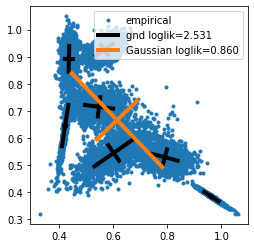

In [10]:
handle0, = pl.plot(x[:,0], x[:,1], '.', zorder=-1, label='empirical')

for c in range(n_clusters):
    handle1, = plot_cov(gnd_mu_[c], gnd_cov_L_[c] @ gnd_cov_L_[c].T,
                       color='k', lw=4, label='gnd')

handle2, = plot_cov(g_mean, g_cov, color='C1', lw=4, label='Gaussian')

pl.legend([handle0, handle1, handle2], [
    'empirical',
    'gnd loglik={:.3f}'.format(mixture_full_log_pdf(
        x, gnd_mu_, np.linalg.inv(gnd_cov_L_)).mean()),
    'Gaussian loglik={:.3f}'.format(Gaussian_log_pdf(
        x, g_mean, np.linalg.inv(np.linalg.cholesky(g_cov))).mean())
], loc='upper right')
pl.axis('square')

# full rank

In [11]:
model = GMMModel(n_clusters, ndims)
model.initialize()
trainer = GMMTrainer(model)

for t, epoch in elapsed(range(100)):
    trainer(x)
    if np.allclose(np.log2(epoch+1), np.round(np.log2(epoch+1))):
        loglik = model(mx.nd.array(x))[0].mean().asscalar()
        print(f'{epoch+1} loglik={loglik:.3f} elapsed={t:.1f}s')

loglik = model(mx.nd.array(x))[0].mean().asscalar()
print(f'{epoch+1} loglik={loglik:.3f} elapsed={t:.1f}s')

1 loglik=0.860 elapsed=0.0s
2 loglik=0.860 elapsed=0.0s
4 loglik=0.860 elapsed=0.1s
8 loglik=0.861 elapsed=0.2s
16 loglik=1.273 elapsed=0.5s
32 loglik=2.031 elapsed=0.9s
64 loglik=2.533 elapsed=1.7s
100 loglik=2.533 elapsed=2.7s


In [12]:
mu_ = model.mu_.data().asnumpy()
kR_ = model.kR_.data().asnumpy()
cov_ = np.linalg.inv(kR_.swapaxes(1,2) @ kR_)

(0.2941210180312009,
 1.0967109330507165,
 0.28322551523446604,
 1.0858154302539818)

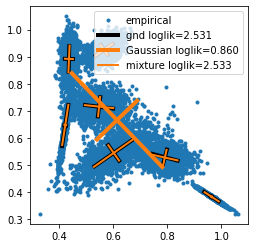

In [13]:
handle0, = pl.plot(x[:,0], x[:,1], '.', zorder=-1, label='empirical')

for c in range(n_clusters):
    handle1, = plot_cov(gnd_mu_[c], gnd_cov_L_[c] @ gnd_cov_L_[c].T,
                       color='k', lw=4, label='gnd')

handle2, = plot_cov(g_mean, g_cov, color='C1', lw=4, label='Gaussian')

for c in range(n_clusters):
    handle3, = plot_cov(mu_[c], cov_[c], color='C1', lw=2,
                        label='EM full rank')

pl.legend([handle0, handle1, handle2, handle3], [
    'empirical',
    'gnd loglik={:.3f}'.format(mixture_full_log_pdf(
        x, gnd_mu_, np.linalg.inv(gnd_cov_L_)).mean()),
    'Gaussian loglik={:.3f}'.format(Gaussian_log_pdf(
        x, g_mean, np.linalg.inv(np.linalg.cholesky(g_cov))).mean()),
    'mixture loglik={:.3f}'.format(mixture_full_log_pdf(
        x, mu_, kR_).mean()),
], loc='upper right')
pl.axis('square')